In [1]:
%matplotlib inline
import scrublet as scr
import scipy.io
import matplotlib.pyplot as plt
import os
import numpy as np

### Download 8k PBMC data set from 10X Genomics
##### Only do this once

In [ ]:
# Download raw data by navigating to the following URL in your web browser:
# http://cf.10xgenomics.com/samples/cell-exp/2.1.0/pbmc8k/pbmc8k_filtered_gene_bc_matrices.tar.gz

# Or use wget
!wget http://cf.10xgenomics.com/samples/cell-exp/2.1.0/pbmc8k/pbmc8k_filtered_gene_bc_matrices.tar.gz

In [ ]:
# Uncompress 
!tar xfz pbmc8k_filtered_gene_bc_matrices.tar.gz

### Load counts matrix and gene list

In [2]:
# path to counts matrix and gene list
input_dir = 'filtered_gene_bc_matrices/GRCh38/'

#### The first time this is run, the counts matrix is loaded from the mtx file. An npz file is saved for fast loading in the future.

In [3]:
# The raw counts matrix (E) should be a scipy sparse CSC matrix
# with cells as rows and genes as columns

if os.path.isfile(input_dir + '/matrix.npz'):
    E = scipy.sparse.load_npz(input_dir + '/matrix.npz')
else:
    E = scipy.io.mmread(input_dir + '/matrix.mtx').T.tocsc()
    scipy.sparse.save_npz(input_dir + '/matrix.npz', E, compressed=True)

print(E.shape)

(8381, 33694)


#### Load gene names, appending "\__1", "\__2", etc. to genes that appear more than once.

In [4]:
genes = np.array(scr.load_genes(input_dir + 'genes.tsv', delimiter='\t', column=1))

### Check that the distribution of total counts per cell looks reasonable

Text(0,0.5,'Number of cells')

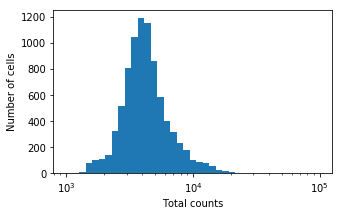

In [5]:
total_counts = E.sum(1).A.squeeze()

fig, ax = plt.subplots(figsize = (5, 3))
ax.hist(total_counts, bins = np.logspace(3, 5, 40))
ax.set_xscale('log')
ax.set_xlabel('Total counts')
ax.set_ylabel('Number of cells')


### Cell-level normalization by total counts

In [6]:
E_norm = scr.tot_counts_norm(E)[0]

### Filter genes based on expression level and variability

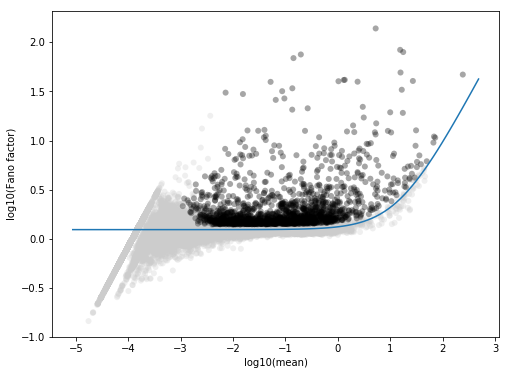

1697 genes pass filter


In [7]:
gene_filter = scr.filter_genes(E_norm, min_vscore_pctl=85, min_counts=2, min_cells=3, show_vscore_plot=True)
print('{} genes pass filter'.format(len(gene_filter)))

### Run PCA

In [9]:
pca = scr.get_pca(E_norm[:,gene_filter], numpc = 30, keep_sparse = False, normalize = True)

### Calculate doublet scores

In [10]:
# Outputs: 
#  doub_score: doublet scores for each cell
#  doub_score_sim: doublet scores for simulated doublets; used for determining threshold for calling doublets

doub_score, doub_score_sim = scr.predict_doublets(precomputed_pca=pca, 
                                                  exp_doub_rate = 0.1,
                                                  total_counts=total_counts,
                                                  sim_doublet_ratio=3,
                                                  k=50, 
                                                  use_approx_nn=True
                                                 )

Simulating doublets
Running KNN classifier
Using approximate nearest neighbor search


### We'll want to visualize the doublet predictions on a 2-D embedding
Get a force-directed graph layout

In [11]:
edges = scr.get_knn_graph(pca, k=4, approx=False)[0]
coords = scr.get_force_layout(edges, pca.shape[0], n_iter=1000, verbose=True, 
                                    gravity = 0.05, jitterTolerance=0.1)

Using sklearn NearestNeighbors
kNN graph built in 1.857 sec


 16%|█▌        | 158/1000 [00:10<00:53, 15.73it/s]/Users/sam/miniconda3/envs/py27/lib/python2.7/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 1000/1000 [01:08<00:00, 14.64it/s]


('BarnesHut Approximation', ' took ', '36.02', ' seconds')
('Repulsion forces', ' took ', '25.71', ' seconds')
('Gravitational forces', ' took ', '0.27', ' seconds')
('Attraction forces', ' took ', '0.38', ' seconds')
('AdjustSpeedAndApplyForces step', ' took ', '1.49', ' seconds')


### Check out the doublet score distribution. Manually set a threshold between the two peaks of the simulated doublet histogram.

402/8381 = 4.8% of cells are predicted doublets.
63.3% of doublets are predicted to be detectable.


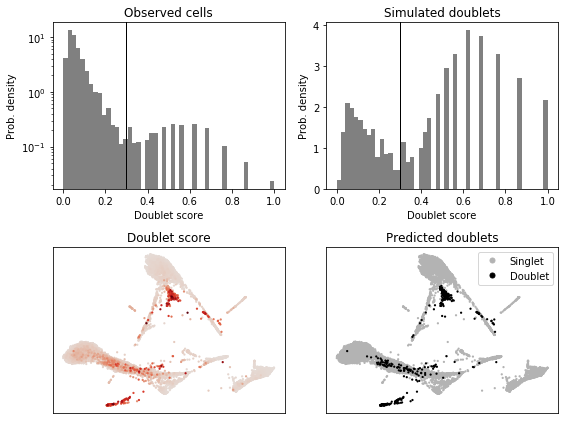

In [16]:
score_threshold = 0.3
fig, axs = scr.plot_scrublet_results(coords, doub_score, doub_score_sim, 
                                     score_threshold, order_points=True)

### Orient yourself by plotting some marker genes on the force layout
Note that none of the doublet clusters has unique marker genes

In [17]:
marker_genes = ['CD3D', 'NKG7', 'CD79A', 'LYZ', 'FCGR3A', 'FCER1A', 'IL3RA', 'PPBP']

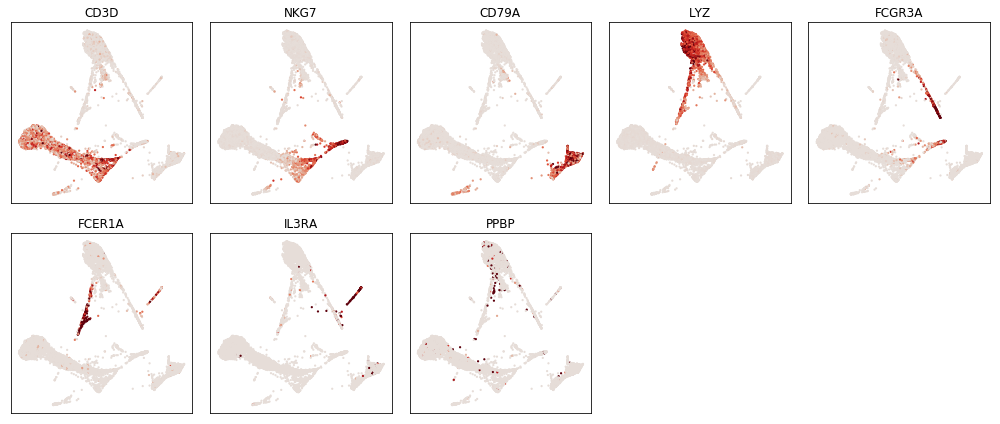

In [18]:
genes_to_plot = marker_genes

x = coords[:,0]
y = coords[:,1]

ncol = 5
nrow = len(genes_to_plot) / ncol + 1
fig = plt.figure(figsize = (14.0 / 5 * ncol, 3 * nrow))
for iG, g in enumerate(genes_to_plot):
    ax = plt.subplot(nrow, ncol, iG + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(g)
    
    k = list(genes).index(g)
    color_dat = E_norm[:,k].A.squeeze()
    
    ax.scatter(x, y, c = color_dat, s = 5, cmap = scr.darken_cmap(plt.cm.Reds,0.9), 
               vmax = np.percentile(color_dat, 99), edgecolors='')
    
fig.tight_layout()